# Preamble
**Context**

   The climate at a specific location (as recorded by observations) can be seen as a sample from a "real" probability distribution function (PDF). We have a number of climate models, from many agencies across the world, that use physics to approximate this underlying PDF. Each simulation run of each of these models can be seen as a sample from the PDF embodied by the code in that model.

   Some agencies publish the results of multiple simulation runs for their models while others publish a single set of predictions (from either a single simulation or an aggregation of multiple simulations).

   Each model defines a set of polygons covering the earth. Results are typically hourly predictions (over the next several decades, starting from 10-20 years ago), for a number of variables (such as the maximum and minimum temperatures, precipitation) for each of the polygons. The polygons are typically 100km x 100km or 0.5arc degree S2 cells. Combining results from different models is complicated by the differences in these geometries. Further, the large size of these polygons means that it is difficult to make predictions about most cities and counties, which are much smaller. Fortunately, NASA produces downscaled, normalized versions of the outputs of the most well regarded models. We use these downscaled models for our analysis.

   Models also tend to have a bias, i.e., they either over or under estimate the temperature. Since the models typically start their prediction at some time in the past (e.g., 2005), the differences between observed and predicted values can be used to estimate and compensate for these biases. The NASA downscaled data incorporates this bias correction.

   We would like to answer the following class of questions: given a place (typically an administrative area), what is the highest / lowest temperature that is likely to be reached, for some period of time (e.g., one day), during some period of time (e.g., 2024 or 2030-2040) with X% likelihood (for X=1% and X=5%). To answer these questions, we first reconstruct the PDF of the variable (highest or lowest temperature) in question and then answer the question by sampling from this PDF.

   Consider the case of estimating the highest temperature $T$ on a single day, in a single given year, with a likelihood of $X$%. To do this, we
   1.  construct the PDF of daily highest temperature.
   2.  pick a $T$. Let the cumulative probability of the highest temperature being less than $T$ on a randomly chosen day be $p$.
   3. We compute the probability of the temperature being less than $T$ on every day of that year. We iterate on $T$ till we find a $T$ where this probability is $1-X$.


   **Constructing the PDF**

   We have some number of models (see below for the list of models we use in this analysis) and for each we have a table of maximum temperature and date. From this, we construct the PDF. We try the following approaches.
   1. We quantize the temperature into $1^oC$ ranges and build the histogram of temperatures vs the number of days where that is the highest temperature. The probability of the highest temperature being $T$ can be read off this histogram. This is a very conservative approach, where the temperatures are bound to within the range of predictions for that year. Given that the table from the model itself is just an estimate, the actual highest temperature could indeed be higher than what is in the table. The next approach tries to do this.
   2. We can fit a distribution to the points in the table. We experiment with Gaussian, Gamma, and mixture of Gaussians. We notice that the problem with simple Gaussian and Gamma is that while they do predict much higher temperatures, they are not aware of physical limits (e.g., they assign a non-zero probability to the temperature exceeding $100^oC$). So, as the time period (over which the prediction is done) gets longer, the probability of much more extreme events goes up, well into unrealistic territory. We notice that mixture of Gaussians does have more realistic behaviour.

   The purpose of this exercise is to enable planning for extreme weather events. We notice that even with the most conservative histogram based approach, there are likely to be days, in the next decade, where the temperature exceeds $50^oC$, a dangerous threshold.

   **Independence**

   Let the cumulative probability of the temperature being less than $T$ on a randomly chosen day be $p$. If the temperatures on different days were indepdentent of each other, the probability of the peak temperature exceeding $T$ on at least one day in the year would simply be $(1 - p^{N})$, where $N=365$. However, the temperature on consecutive days are not independent of each other. In this analysis, we approximately capture this by using a lower $N$. For example, if we can assume that the temperatures on days 7 or more days apart are independent, we can use $N=52$.

# Setup

## Imports

In [17]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
from ipywidgets import Box
import ipywidgets as widgets
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
import warnings

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture as GMM

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [18]:
MIN_TEMP_C = -100
MAX_TEMP_C = 120

## General Helper Functions

In [19]:
def convert_to_kelvins(val_c):
  return val_c + 273.15

def convert_to_celsius(val_k):
  return val_k - 273.15

## Data Extracts Retrieval

In [20]:
def get_data_extract(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])
  return pd.read_csv(downloaded.metadata['title'], keep_default_na=False)

## Computing Probabilities - Helpers

In [21]:
def gmm_choose_best_num_mixture(obs):
  opt_bic = None
  min_bic = 0
  counter=1
  for i in range (1, 5, 1): # test the AIC/BIC metric between 1 and 10 components
    gmm = GMM(n_components = i, max_iter=1000, random_state=0, covariance_type = 'full')
    gmm.fit(obs).predict(obs)
    bic = gmm.bic(obs)
    if bic < min_bic or min_bic == 0:
      min_bic = bic
      opt_bic = i

  return opt_bic

In [22]:
def fit_dist(df_subset, dist_type):
  obs_list = df_subset["value"].tolist()
  params = []

  if dist_type == "Gamma":
    params = stats.gamma.fit(obs_list)
  elif dist_type == "Gaussian":
    params  = stats.norm.fit(obs_list)
  elif dist_type == "GaussianMixture":
    obs= np.array(obs_list)
    obs = obs.reshape(-1, 1)
    best_num_mixture = gmm_choose_best_num_mixture(obs)
    # print(f"Best GMM mixture has {best_num_mixture} components.")
    gmm = GMM(n_components = best_num_mixture, max_iter=2000, random_state=0, covariance_type = 'full')
    params = gmm.fit(obs)
  elif dist_type == "Histogram":
    return []

  return params

In [23]:
def generate_smooth_pdf(x_min, x_max, dist_type, params):
  y = []

  bins = []
  for b in range(x_min, x_max):
    bins.append(b)

  if dist_type == "Gamma":
    shape = params[0]
    loc = params[1]
    scale = params[2]
    y = stats.gamma.pdf(bins, shape, loc, scale)
  elif dist_type == "Gaussian":
    loc = params[0]
    scale = params[1]
    y = stats.norm.pdf(bins, loc, scale)
  elif dist_type == "GaussianMixture":
    mean = params.means_
    covs = params.covariances_
    weights = params.weights_

    num_gaussians = mean.shape[0]
    y = None
    for i in range(num_gaussians):
      y_i = stats.norm.pdf(bins, float(mean[i][0]), np.sqrt(float(covs[i][0][0])))*weights[i] # i-th gaussian
      if y is None:
        y = y_i
      else:
        y += y_i

  elif dist_type == "Histogram":
    return []

  return y

In [24]:
def cdf(x, dist_type, params):
  if dist_type == "Gamma":
    shape = params[0]
    loc = params[1]
    scale = params[2]
    return stats.gamma.cdf(x, shape, loc, scale)
  elif dist_type == "Gaussian":
    loc = params[0]
    scale = params[1]
    return stats.norm.cdf(x, loc, scale)
  elif dist_type == "GaussianMixture":
    means = params.means_
    covs = params.covariances_
    weights = params.weights_

    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=np.sqrt(covs[i][0][0])) # i-th gaussian
    return mcdf

In [25]:
def compute_histogram_cdf(df_hist_subset):
  sum = 0
  temp2pdf = dict(zip(df_hist_subset['temp'], df_hist_subset['prob']))
  temp2cdf = {}
  for temp in range(int(MIN_TEMP_C), int(MAX_TEMP_C)):
    sum += temp2pdf.get(temp, 0)
    temp2cdf[temp] = sum
  return temp2cdf

In [26]:
def icdf_percent_n(dist_type, temp2cdf_hist, params, var="Max_Temperature", percent=0.01, n=1):
  low = MIN_TEMP_C
  high = MAX_TEMP_C
  mid = int((low + high) / 2.0)

  is_max = True
  if "Min" in var:
    is_max = False

  if dist_type == "Histogram":
    curr_cdf = temp2cdf_hist[mid]
  else:
    curr_cdf = cdf(mid, dist_type, params)

  if is_max:
    icdf = 1.0 - (curr_cdf**n)
  else:
    icdf = 1.0 - (1.0 - curr_cdf)**n

  iter = 0;
  while (abs(icdf - percent) > 0.00025):
    if iter > 500:
      return mid
    if (icdf > percent):
      if is_max:
        low = mid
      else:
        high = mid
    else:
      if is_max:
        high = mid
      else:
        low = mid

    mid = int((low + high) / 2.0)
    if dist_type == "Histogram":
      curr_cdf = temp2cdf_hist[mid]
    else:
      curr_cdf = cdf(mid, dist_type, params)

    if is_max:
      icdf = 1.0 - (curr_cdf**n)
    else:
      icdf = 1.0 - (1.0 - curr_cdf)**n

    iter += 1
  return mid

## Plotting Helpers

In [27]:
def plot_fits(df_subset, df_hist, df_act, county_name, n, year_start, year_end, ssp, model, var):
  dists = ["NoFitting", "Histogram", "GaussianMixture"] #["Histogram", "Gamma", "Gaussian", "GaussianMixture"]

  num_rows = len(dists)
  num_cols = 1
  fig, axs = plt.subplots(num_rows, num_cols, sharey=False, sharex=True, tight_layout=True)
  fig.set_size_inches(10*num_cols, 4*num_rows, forward=True)

  actual_val_col = "tmax"
  is_max = True
  if "Min" in var:
    is_max = False
    actual_val_col = "tmin"


  x_min = int(df_subset["value"].min()) - 5
  x_max = int(df_subset["value"].max()) + 20
  x_array = list(range(x_min, x_max))
  for i in range(len(dists)):
    # Generate the bins for the data and show the histogram.

    nbins = x_max - x_min
    # If there is no actual data, only plot the CMIP6 model data.
    count, bins, ignored = axs[i].hist(df_subset["value"], nbins, density=True, color='lavender', label="CMIP6 Model Data Histogram")
    if not df_act.empty:
      # If there is actual data, plot two histograms on top of each other. One histogram is represented as dots.
      count_, bins_  = np.histogram(df_act[actual_val_col], nbins, density=True)
      axs[i].scatter(bins_[:-1], count_, s=5, color='gray', label="Actual Data Histogram (dots)")

    no_fitting = False
    dist = dists[i]
    if dist == "NoFitting":
      # When "NoFitting" is chosen, this just means N = 1 for the "histogram fit".
      dist = "Histogram"
      no_fitting = True

    params = fit_dist(df_subset, dist)

    # No smoothed_pdf produced for the Histogram fit.
    smoothed_pdf_y = generate_smooth_pdf(x_min, x_max, dist, params)
    if len(smoothed_pdf_y):
      axs[i].plot(x_array, smoothed_pdf_y, linewidth=3, color='r', label=f"{dist} \nFitted (to CMIP6 Model Data)")

    # Get the 1% and 5% thresholds.
    temp2cdf_hist = compute_histogram_cdf(df_hist)

    if no_fitting:
      n_to_use = 1
    else:
      n_to_use = n

    p01 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.01, n=n_to_use)
    p05 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.05, n=n_to_use)
    p50 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.5, n=n_to_use)
    p95 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.95, n=n_to_use)

    # Add the p01 and p05 lines on the axes.
    axs[i].axvline(p95, linestyle='--', color='limegreen', linewidth=2, label="95% threshold = {0}C".format(p95))
    axs[i].axvline(p50, linestyle='--', color='blue',  linewidth=2, label="50% threshold = {0}C".format(p50))
    axs[i].axvline(p05, linestyle='--', color='darkorange', linewidth=2, label="5% threshold = {0}C".format(p05))
    axs[i].axvline(p01, linestyle='--', color='crimson',  linewidth=2, label="1% threshold = {0}C".format(p01))


    # Add labels and title to the plot
    if is_max:
      axs[i].set_xlabel('Max Temperature (in C)')
    else:
      axs[i].set_xlabel('Min Temperature (in C)')
    axs[i].set_ylabel('Probability Density')

    if no_fitting:
      axs[i].set_title(f'{model} ({ssp}). No Fitting (N= {n_to_use}). Period: ({year_start}-{year_end}). {county_name}')
    else:
      axs[i].set_title(f'{model} ({ssp}). Fit: {dist} (N= {n_to_use}). Period: ({year_start}-{year_end}). {county_name}')
    if is_max:
      axs[i].legend(loc="upper left")
    else:
      axs[i].legend(loc="upper right")

    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)


  plt.show()

In [28]:
def plot_trends(data_p1d, data_hist, county_dcid, ssp, model, var, n):
  dists = ["NoFitting", "Histogram", "GaussianMixture"] #["Histogram", "Gamma", "Gaussian", "GaussianMixture"]

  year_starts = [1980, 1990, 2000, 2020, 2030, 2040]
  colors_y = ['cyan', 'green', 'blue', 'gold', 'orange', 'red']

  num_rows = len(dists) + 1
  num_cols = 1
  fig, axs = plt.subplots(num_rows, num_cols, sharey=False, sharex=False, tight_layout=True)
  fig.set_size_inches(8*num_cols, 3*num_rows, forward=True)


  is_max = True
  if "Min" in var:
    is_max = False

  df_hist_ext = data_hist[var]
  df_future_ext = data_p1d[(var, "future")]
  df_past_ext = data_p1d[(var, "past")]

  # Filters.
  df_future_ext = df_future_ext[(df_future_ext['scenario'] == ssp) &
                                (df_future_ext['county'] == county_dcid)]
  df_past_ext = df_past_ext[(df_past_ext['scenario'] == "historical") &
                              (df_past_ext['county'] == county_dcid)]

  if Model != 'Ensemble':
    df_future_ext = df_future_ext[df_future_ext["cmip6_model"] == model]
    df_past_ext = df_past_ext[df_past_ext["cmip6_model"] == model]

  df_hist_past_ext = df_hist_ext[(df_hist_ext['scenario'] == '') &
                            (df_hist_ext['county'] == county_dcid) &
                             (df_hist_ext['cmip6_model'] == model)]
  df_hist_future_ext = df_hist_ext[(df_hist_ext['scenario'] == ssp) &
                            (df_hist_ext['county'] == county_dcid) &
                             (df_hist_ext['cmip6_model'] == model)]


  x_min = min(int(df_future_ext["value"].min()) - 5, int(df_past_ext["value"].min()) - 5)
  x_max = max(int(df_future_ext["value"].max()) + 20, int(df_past_ext["value"].max()) + 20)
  x_array = list(range(x_min, x_max))
  for i in range(len(dists)):

    no_fitting = False
    dist = dists[i]
    if dist == "NoFitting":
      dist = "Histogram"
      no_fitting = True

    p95s = []
    p50s = []
    p05s = []
    p01s = []
    fit_params = []
    for y in year_starts:
      y_end = y + 10

      # We have two cases: past (prior to 2010) and future (after 2010).
      if y < 2010:
        df_hist_y = df_hist_past_ext[(df_hist_past_ext["year"] >= y) & (df_hist_past_ext["year"] < y_end)]
        df_subset_y = df_past_ext[(df_past_ext["year"] >= y) & (df_past_ext["year"] < y_end)]
      else:
        df_hist_y = df_hist_future_ext[(df_hist_future_ext["year"] >= y) & (df_hist_future_ext["year"] < y_end)]
        df_subset_y = df_future_ext[(df_future_ext["year"] >= y) & (df_future_ext["year"] < y_end)]

      if df_hist_y.empty or df_subset_y.empty:
        print("No data matched this selection. Please try a different selection.")
        return

      temp2cdf_hist = compute_histogram_cdf(df_hist_y)

      params = fit_dist(df_subset_y, dist)
      fit_params.append(params)

      if no_fitting:
        n_to_use = 1
      else:
        n_to_use = n

      # Trends for the various probability levels.
      p01 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.01, n=n_to_use)
      p05 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.05, n=n_to_use)
      p50 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.5, n=n_to_use)
      p95 = icdf_percent_n(dist, temp2cdf_hist, params, var=var, percent=0.95, n=n_to_use)

      p95s.append(p95)
      p50s.append(p50)
      p05s.append(p05)
      p01s.append(p01)


    # Plot trend for the dist.
    axs[i].plot(year_starts, p95s, 'yellowgreen', label='p95')
    axs[i].plot(year_starts, p50s, 'mediumorchid', label='p50')
    axs[i].plot(year_starts, p05s, 'darkorange', label='p05')
    axs[i].plot(year_starts, p01s, 'maroon', label='p01')
    if no_fitting:
      axs[i].set_title(f"{var}, No Distribution, N={n_to_use}")
    else:
      axs[i].set_title(f"{var}, {dist} fit, N={n_to_use}")
    axs[i].set_xlabel("Decade")
    axs[i].set_ylabel(f"{var} (C)")
    axs[i].legend(loc="upper left")
    axs[i].xaxis.set_tick_params(which='both', labelbottom=True)

    # Please the fitted PDF for the Gaussian Mixture.
    if dist == "GaussianMixture":
      for y_ind in range(len(year_starts)):
        smoothed_pdf_y = generate_smooth_pdf(x_min, x_max, dist, fit_params[y_ind])
        if len(smoothed_pdf_y):
          axs[num_rows - 1].plot(x_array, smoothed_pdf_y, linewidth=1.5, color=colors_y[y_ind], label=f"{year_starts[y_ind]}")
      axs[num_rows - 1].set_title(f"{var}, GaussianMixture Fits Across Decades, N={n_to_use}")
      axs[num_rows - 1].set_xlabel(f"{var} (C)")
      axs[num_rows - 1].set_ylabel(f"Probability")
      axs[num_rows - 1].legend(loc="upper left")


  plt.show()

# Pre-Computation (Takes a Minute or Two)

The data for 100 counties across the US is made available as an extract on a Google Drive location. This data is retrieved directly and the distribution parameters are then estimated (here in this colab). The histogram fitting is precomputed (using SQL), the code for which is provided at: https://gist.github.com/pradh/2fda9a4e30f7fd9d0086ec685e94aeb5 (but not used directly in this Colab).

In [29]:
#@title Counties List (Do Not Edit)
COUNTIES_MAP = {
  'Kern County': 'geoId/06029',
  'Atkinson County': 'geoId/13003',
  'Pierce County': 'geoId/13229',
  'Ware County': 'geoId/13299',
  'Brantley County': 'geoId/13025',
  'Telfair County': 'geoId/13271',
  'Charlton County': 'geoId/13049',
  'Imperial County': 'geoId/06025',
  'Inyo County': 'geoId/06027',
  'Riverside County': 'geoId/06065',
  'Cheyenne County': 'geoId/08017',
  'Highlands County': 'geoId/12055',
  'Clinch County': 'geoId/13065',
  'Wheeler County': 'geoId/13309',
  'Garfield County': 'geoId/30033',
  'Chesterfield County': 'geoId/45025',
  'Okeechobee County': 'geoId/12093',
  'Polk County': 'geoId/12105',
  'Berrien County': 'geoId/13019',
  'La Paz County': 'geoId/04012',
  'Maricopa County': 'geoId/04013',
  'Yuma County': 'geoId/04027',
  'San Bernardino County': 'geoId/06071',
  'Hardee County': 'geoId/12049',
  'Osceola County': 'geoId/12097',
  'Bacon County': 'geoId/13005',
  'Coffee County': 'geoId/13069',
  'Irwin County': 'geoId/13155',
  'Jeff Davis County': 'geoId/13161',
  'Lanier County': 'geoId/13173',
  'Todd County': 'geoId/21219',
  'Frontier County': 'geoId/31063',
  'Union County': 'geoId/37179',
  'Hill County': 'geoId/48217',
  'McMullen County': 'geoId/48311',
  'Montague County': 'geoId/48337',
  'Dodge County': 'geoId/13091',
  'Marlboro County': 'geoId/45069',
  'Christian County': 'geoId/21047',
  'Mohave County': 'geoId/04015',
  'Pima County': 'geoId/04019',
  'Crowley County': 'geoId/08025',
  'Prowers County': 'geoId/08099',
  'Hamilton County': 'geoId/12047',
  'Hillsborough County': 'geoId/12057',
  'Baker County': 'geoId/13007',
  'Bulloch County': 'geoId/13031',
  'Camden County': 'geoId/13039',
  'Echols County': 'geoId/13101',
  'Emanuel County': 'geoId/13107',
  'Jefferson County': 'geoId/13163',
  'Lowndes County': 'geoId/13185',
  'Mitchell County': 'geoId/13205',
  'Montgomery County': 'geoId/13209',
  'Treutlen County': 'geoId/13283',
  'Washington County': 'geoId/13303',
  'Wayne County': 'geoId/13305',
  'Wilcox County': 'geoId/13315',
  'Scott County': 'geoId/18143',
  'Logan County': 'geoId/21141',
  'Trimble County': 'geoId/21223',
  'Petroleum County': 'geoId/30069',
  'Luna County': 'geoId/35029',
  'Anson County': 'geoId/37007',
  'Randolph County': 'geoId/37151',
  'Richmond County': 'geoId/37153',
  'Robeson County': 'geoId/37155',
  'Beckham County': 'geoId/40009',
  'Cherokee County': 'geoId/45021',
  'Fairfield County': 'geoId/45039',
  'Kershaw County': 'geoId/45055',
  'Lancaster County': 'geoId/45057',
  'Newberry County': 'geoId/45071',
  'Saluda County': 'geoId/45081',
  'Perkins County': 'geoId/46105',
  'Brazos County': 'geoId/48041',
  'Burleson County': 'geoId/48051',
  'La Salle County': 'geoId/48283',
  'Orange County': 'geoId/12095',
  'Cook County': 'geoId/13075',
  'Jenkins County': 'geoId/13165',
  'Johnson County': 'geoId/13167',
  'Laurens County': 'geoId/13175',
  'Worth County': 'geoId/13321',
  'Beaver County': 'geoId/40007',
  'Butler County': 'geoId/01013',
  'Choctaw County': 'geoId/01023',
  'Coffee County': 'geoId/01031',
  'Colbert County': 'geoId/01033',
  'Covington County': 'geoId/01039',
  'Dale County': 'geoId/01045',
  'Dallas County': 'geoId/01047',
  'Henry County': 'geoId/01067',
  'Lauderdale County': 'geoId/01077',
  'Marengo County': 'geoId/01091',
  'Wilcox County': 'geoId/01131',
  'Cochise County': 'geoId/04003',
  'Otero County': 'geoId/08089',
  'Columbia County': 'geoId/12023',
  'Manatee County': 'geoId/12081',
}

In [30]:
#@title Retrieve Data Extracts (takes some time)

# Data files available at: # https://drive.google.com/drive/folders/1_DlM5aBfw7JWKZ0-Yu25LIUVZIqfpHCw
df_p1d_max_temp_future = get_data_extract('1_TX4LQBd1klb-BMmE5V6Ih-0IzZjqwBk')
df_p1d_max_temp_past = get_data_extract('1LO3wYpXSM_YaLF5-UjdfVuQQ0YrCAasu')

df_p1d_min_temp_future = get_data_extract('1fjC0xsFQ8CRQDqeesil3t2ihP7dr_1uI')
df_p1d_min_temp_past = get_data_extract('1FQ2xkQPadol-DnDZKbslqAEfBjv0wirx')

df_hist_max_temp = get_data_extract('13ygyBJ-fiD4S3smcm0t_cW6ZHge5RXEE')
df_hist_min_temp = get_data_extract('1N7uocOrCS7_vQ8O9o7Zy-nQl2KBMHeQG')

df_hist_max_temp.rename(columns={"decade": "year", "model": "cmip6_model"}, inplace=True)
df_hist_min_temp.rename(columns={"decade": "year", "model": "cmip6_model"}, inplace=True)

data_p1d = {
    ("Max_Temperature", "future"): df_p1d_max_temp_future,
    ("Max_Temperature", "past"): df_p1d_max_temp_past,
    ("Min_Temperature", "future"): df_p1d_min_temp_future,
    ("Min_Temperature", "past"): df_p1d_min_temp_past,
}
data_hist = {
    "Max_Temperature": df_hist_max_temp,
    "Min_Temperature": df_hist_min_temp,
}

# Actual Observations (from 1980-2020).
df_actual = get_data_extract('19fOHb8cA8MmNVUAoZ-5b7YRT1D3Eq8t_')
df_actual["year"] = df_actual.date.str.slice(0, 4)
df_actual["year"] = df_actual["year"].astype('int')

# Fitted Distributions; Probability Thresholds


Place Page (Imperial County): https://datacommons.org/place/geoId/06025



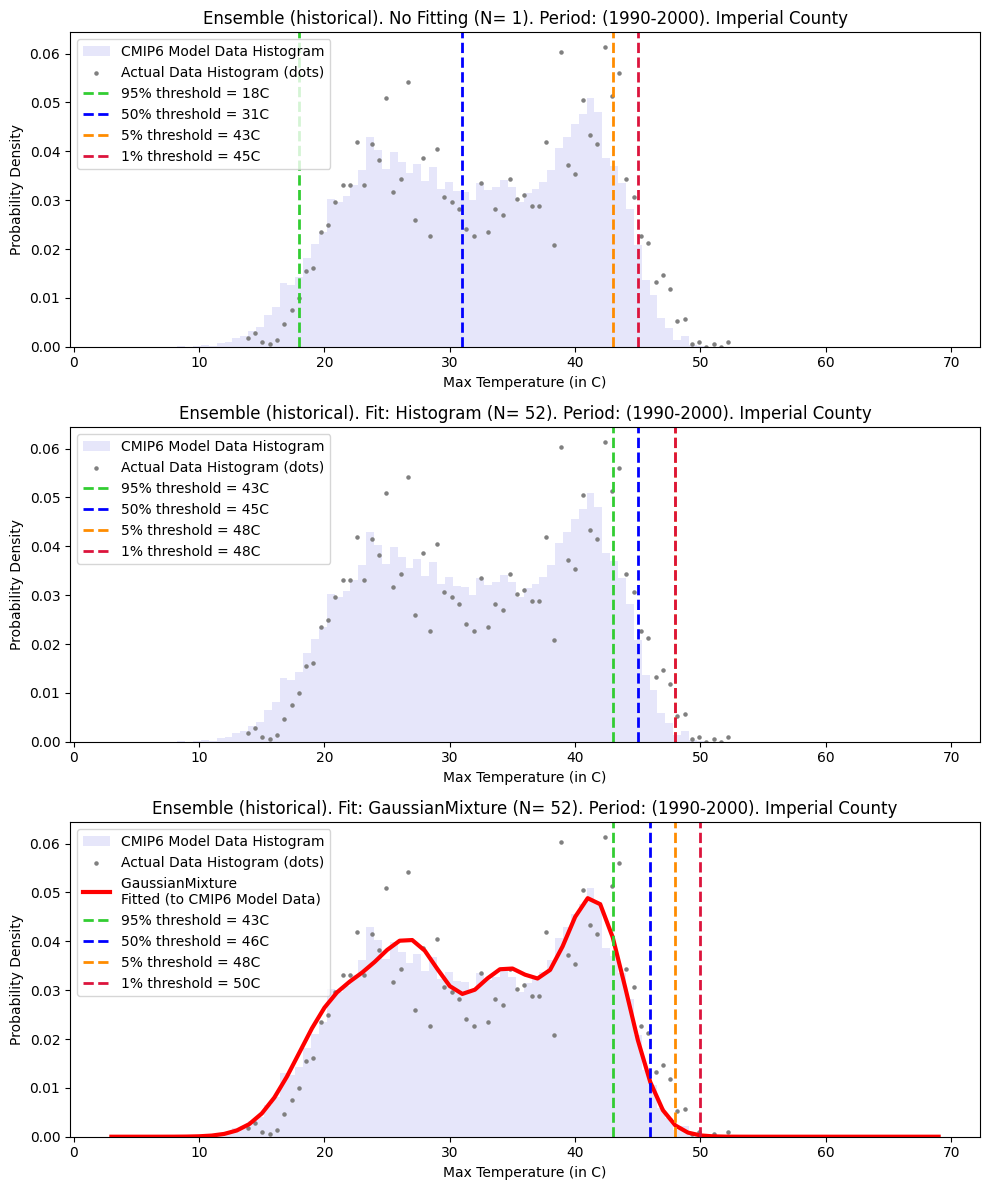

In [31]:
#@markdown Specify a county, variable, scenario, cmip6 model, start year (decade) and specify a positive integer N (read the preamble for an explanation).
#@markdown <br><b>Note: That the SSP245, SSP585 scenarios are only applicable post-2020 while the 'historical' scenario is only applicable prior to 2010.</b>

County = "Imperial County" #@param ['Anson County', 'Atkinson County', 'Bacon County', 'Baker County', 'Beaver County', 'Beckham County', 'Berrien County', 'Brantley County', 'Brazos County', 'Bulloch County', 'Burleson County', 'Butler County', 'Camden County', 'Charlton County', 'Cherokee County', 'Chesterfield County', 'Cheyenne County', 'Choctaw County', 'Christian County', 'Clinch County', 'Cochise County', 'Coffee County', 'Colbert County', 'Columbia County', 'Cook County', 'Covington County', 'Crowley County', 'Dale County', 'Dallas County', 'Dodge County', 'Echols County', 'Emanuel County', 'Fairfield County', 'Frontier County', 'Garfield County', 'Hamilton County', 'Hardee County', 'Henry County', 'Highlands County', 'Hill County', 'Hillsborough County', 'Imperial County', 'Inyo County', 'Irwin County', 'Jeff Davis County', 'Jefferson County', 'Jenkins County', 'Johnson County', 'Kern County', 'Kershaw County', 'La Paz County', 'La Salle County', 'Lancaster County', 'Lanier County', 'Lauderdale County', 'Laurens County', 'Logan County', 'Lowndes County', 'Luna County', 'Manatee County', 'Marengo County', 'Maricopa County', 'Marlboro County', 'McMullen County', 'Mitchell County', 'Mohave County', 'Montague County', 'Montgomery County', 'Newberry County', 'Okeechobee County', 'Orange County', 'Osceola County', 'Otero County', 'Perkins County', 'Petroleum County', 'Pierce County', 'Pima County', 'Polk County', 'Prowers County', 'Randolph County', 'Richmond County', 'Riverside County', 'Robeson County', 'Saluda County', 'San Bernardino County', 'Scott County', 'Telfair County', 'Todd County', 'Treutlen County', 'Trimble County', 'Union County', 'Ware County', 'Washington County', 'Wayne County', 'Wheeler County', 'Wilcox County', 'Worth County', 'Yuma County']
Variable = "Max_Temperature" #@param ["Max_Temperature", "Min_Temperature"]
Scenario = 'historical' #@param ["SSP245", "SSP585", "historical"]
Model = 'Ensemble' #@param ['Ensemble', 'GFDL-CM4','GFDL-ESM4','HADGEM3-GC31-LL','HADGEM3-GC31-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
Decade_Start = '1990' #@param ["2040", "2030", "2020", "2000", "1990", "1980"]
N = "52" #@param {type:"string"}


year_start = int(Decade_Start)
year_end = year_start + 10
proceed = False
try:
  N = int(N)
  if N > 0:
    proceed = True
except:
  pass

if not N:
  print("N must be a positive integer")

county_dcid = COUNTIES_MAP[County]

print()
print(f"Place Page ({County}): https://datacommons.org/place/{county_dcid}")
print()

hist_scenario = Scenario
tuple_1 = Variable
tuple_2 = "future"
if Scenario == "historical":
  hist_scenario = ''
  tuple_2 = "past"

if tuple_2 == "future":
  print("Note: there is no actual observed data for this decade")

df_p1d = data_p1d[(tuple_1, tuple_2)]
df_hist = data_hist[tuple_1]

# Get the Data from BQ.
if proceed:
  df_all_extract = df_p1d[(df_p1d["year"] >= year_start) & (df_p1d["year"] < year_end) &
   (df_p1d['scenario'] == Scenario) & (df_p1d['county'] == county_dcid)]

  if Model != 'Ensemble':
    df_all_extract = df_all_extract[df_all_extract["cmip6_model"] == Model]

  df_hist_extract = df_hist[(df_hist["year"] >= year_start) & (df_hist["year"] < year_end) &
   (df_hist['scenario'] == hist_scenario) & (df_hist['county'] == county_dcid) & (df_hist['cmip6_model'] == Model)]

  df_actual_extract = df_actual[(df_actual["year"] >= year_start) &
                                (df_actual["year"] < year_end) &
                                (df_actual["dcid"] == county_dcid)]
  if (not df_all_extract.empty) and (not df_hist_extract.empty):
    plot_fits(df_all_extract, df_hist_extract, df_actual_extract, County, N, year_start, year_end, Scenario, Model, Variable)
  else:
    print("***** This combination of Variable, Scenario and Model is not valid. Please try a different combination. ******")
    print(len(df_all_extract), len(df_hist_extract))


# Trends Over Decades: Proability Levels; Mixture Distribution Fits


Place Page (Kern County): https://datacommons.org/place/geoId/06029



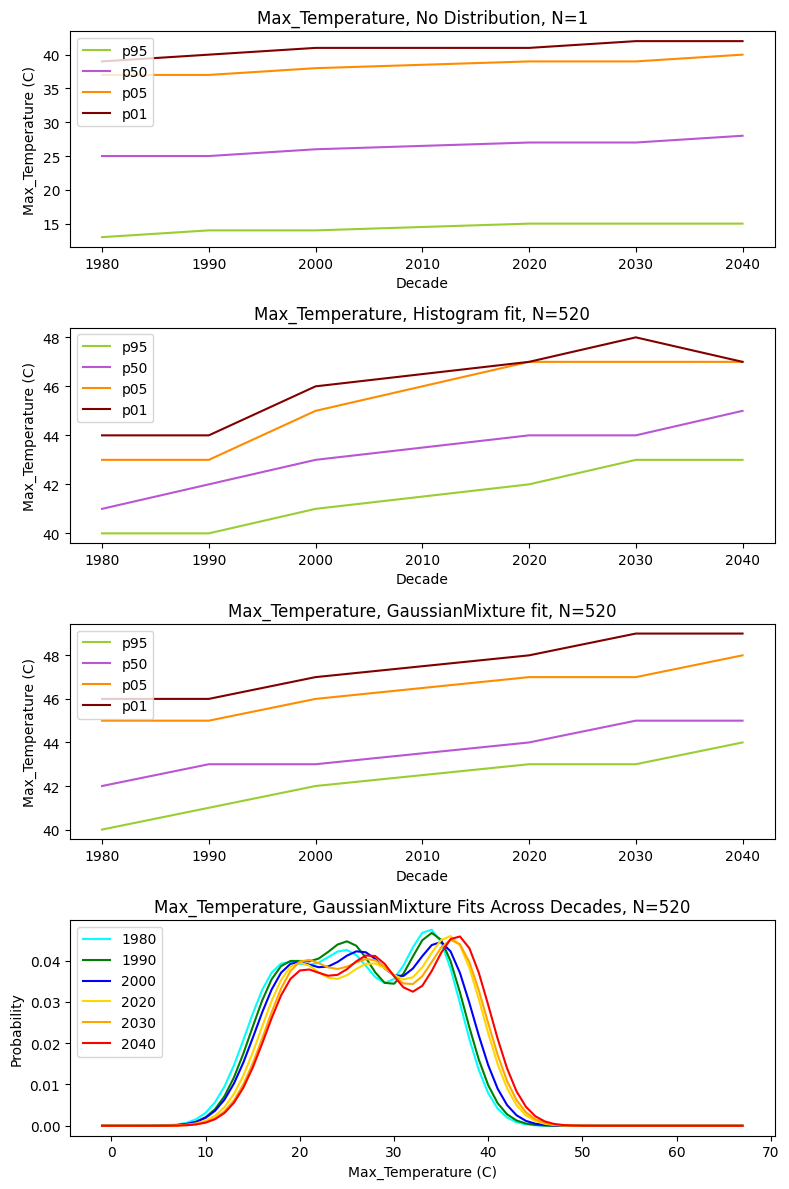

In [32]:
#@markdown Specify a county, variable, scenario, cmip6 model, and specify a positive integer N (read the preamble for an explanation).
#@markdown <br><b>Note: Before 2010, only historical runs are used and after 2010 the selection SSP scenario is used.</b>

County = "Kern County" #@param ['Anson County', 'Atkinson County', 'Bacon County', 'Baker County', 'Beaver County', 'Beckham County', 'Berrien County', 'Brantley County', 'Brazos County', 'Bulloch County', 'Burleson County', 'Butler County', 'Camden County', 'Charlton County', 'Cherokee County', 'Chesterfield County', 'Cheyenne County', 'Choctaw County', 'Christian County', 'Clinch County', 'Cochise County', 'Coffee County', 'Colbert County', 'Columbia County', 'Cook County', 'Covington County', 'Crowley County', 'Dale County', 'Dallas County', 'Dodge County', 'Echols County', 'Emanuel County', 'Fairfield County', 'Frontier County', 'Garfield County', 'Hamilton County', 'Hardee County', 'Henry County', 'Highlands County', 'Hill County', 'Hillsborough County', 'Imperial County', 'Inyo County', 'Irwin County', 'Jeff Davis County', 'Jefferson County', 'Jenkins County', 'Johnson County', 'Kern County', 'Kershaw County', 'La Paz County', 'La Salle County', 'Lancaster County', 'Lanier County', 'Lauderdale County', 'Laurens County', 'Logan County', 'Lowndes County', 'Luna County', 'Manatee County', 'Marengo County', 'Maricopa County', 'Marlboro County', 'McMullen County', 'Mitchell County', 'Mohave County', 'Montague County', 'Montgomery County', 'Newberry County', 'Okeechobee County', 'Orange County', 'Osceola County', 'Otero County', 'Perkins County', 'Petroleum County', 'Pierce County', 'Pima County', 'Polk County', 'Prowers County', 'Randolph County', 'Richmond County', 'Riverside County', 'Robeson County', 'Saluda County', 'San Bernardino County', 'Scott County', 'Telfair County', 'Todd County', 'Treutlen County', 'Trimble County', 'Union County', 'Ware County', 'Washington County', 'Wayne County', 'Wheeler County', 'Wilcox County', 'Worth County', 'Yuma County']
Variable = "Max_Temperature" #@param ["Max_Temperature", "Min_Temperature"]
Scenario = 'SSP585' #@param ["SSP245", "SSP585"]
Model = 'Ensemble' #@param ['Ensemble', 'GFDL-CM4','GFDL-ESM4','HADGEM3-GC31-LL','HADGEM3-GC31-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
N = "520" #@param {type:"string"}


proceed = False
try:
  N = int(N)
  if N > 0:
    proceed = True
except:
  pass

if not N:
  print("N must be a positive integer")

county_dcid = COUNTIES_MAP[County]

print()
print(f"Place Page ({County}): https://datacommons.org/place/{county_dcid}")
print()

if proceed:
  plot_trends(data_p1d, data_hist, county_dcid, Scenario, Model, Variable, N)
